# 8. Seq2seq으로 번역기 만들기
## Step 0. 라이브러리 불러오기

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import os
import re

# print(pandas.__version__)
# print(tensorflow.__version__)
# print(matplotlib.__version__)

## Step 1. 데이터 다운로드

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)

print("완료!")

완료!


In [3]:
path_to_zip = tf.keras.utils.get_file(
    'korean-english-park.train.tar.gz',
    origin='https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz',
    extract=True)

path_to_eng = os.path.dirname(path_to_zip)+"/korean-english-park.train.en"
path_to_kor = os.path.dirname(path_to_zip)+"/korean-english-park.train.ko"

8732672/8718893 [==============================] - 0s 0us/step


In [4]:
path_to_zip

'/aiffel/.keras/datasets/korean-english-park.train.tar.gz'

In [5]:
with open(path_to_eng, "r") as f:
    eng_raw = f.read().splitlines()

print("English Data Size:", len(eng_raw))
print("English Example:")

for sen in eng_raw[0:50]: print(">>", sen)

English Data Size: 94123
English Example:
>> Much of personal computing is about "can you top this?"
>> so a mention a few weeks ago about a rechargeable wireless optical mouse brought in another rechargeable, wireless mouse.
>> Like all optical mice, But it also doesn't need a desk.
>> uses gyroscopic sensors to control the cursor movement as you move your wrist, arm, whatever through the air.
>> Intelligence officials have revealed a spate of foiled plots on ships in Southeast Asia and are warning that a narrow stretch of water carrying almost one third of the world's maritime trade is vulnerable to a terror attack.
>> After learning of several foiled al Qaeda attempts on U.S. and commercial ships in the area, experts are warning that the terror network still wants to cripple the global economy, the world's economic jugular vein in Southeast Asia is at risk.
>> Caffeine can help increase reaction time and improve performance for military servicemen who must perform complex tasks or w

In [6]:
with open(path_to_kor, "r") as f:
    kor_raw = f.read().splitlines()

print("Korean Data Size:", len(kor_raw))
print("Korean Example:")

for sen in kor_raw[0:50]: print(">>", sen)

Korean Data Size: 94123
Korean Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하지 않는다.
>> 그러나 이것은 또한 책상도 필요로 하지 않는다.
>> 79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분이든 그 움직임에따라 커서의 움직임을 조절하는 회전 운동 센서를 사용하고 있다.
>> 정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔음을 밝혔으며, 세계 해상 교역량의 거의 3분의 1을 운송하는 좁은 해로인 말라카 해협이 테러 공격을 당하기 쉽다고 경고하고 있다.
>> 이 지역에 있는 미국 선박과 상업용 선박들에 대한 알카에다의 (테러) 시도 중 여러 건이 실패했다는 것을 알게 된 후에, 전문가들은 테러 조직이 여전히 세계 경제에 타격을 입히려 한다고 경고하고 있으며, 동남 아시아에 있는 세계 경제의 주요 통로가 위험에 처해 있다고 그들은 생각하고 있다.
>> 국립 과학 학회가 발표한 새 보고서에따르면, 복잡한 임무를 수행해야 하는 군인들이나 보다 오랜 시간 동안 경계를 늦추지 않고 있기 위해 도움이 필요한 군인들에게 카페인이 반응 시간을 증가시키고 임무 수행 능력을 향상시키는데 도움이 된다고 한다.
>> 이 보고서에따르면, "특히, 군사 작전에서 생사가 걸린 상황이 될 수도 있는 반응 속도와 시각 및 청각의 경계 상태를 유지시키기 위해 카페인이 사용될 수도 있다." 고 한다.
>> "결정적인 순간에 그들의 능력을 증가시켜 줄 그 무엇이 매우 중요합니다."
>> 연구가들이 이미 커피 대체품으로서 음식 대용 과자나 껌에 카페인을 첨가하는 방법을 연구하고 있다고 Archibald는 말했다.
>> 약 200600밀리그램의, 비슷한 분량의 카페인은 또한 육체적 지구력을 강화시키는 데 효과적인 것 같으며, 특히 고도가 높은 곳에서 약해진 육체적 지구력을 일

In [7]:
kor_raw_df = pd.DataFrame({'Korean' : kor_raw})
eng_raw_df = pd.DataFrame({'English' : eng_raw})

In [8]:
# 한글데이터 확인
kor_raw_df

,Korean
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?"""
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분..."
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...
...,...
94118,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...
94119,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다.
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.


In [9]:
# 영어데이터 확인
eng_raw_df

,English
0,"Much of personal computing is about ""can you t..."
1,so a mention a few weeks ago about a rechargea...
2,"Like all optical mice, But it also doesn't nee..."
3,uses gyroscopic sensors to control the cursor ...
4,Intelligence officials have revealed a spate o...
...,...
94118,””We are hoping to seize material evidence to ...
94119,"” On Monday, police secured statements from si..."
94120,But the lack of material evidence is making it...
94121,Kim and his son both deny the allegations.


In [10]:
raw_df = pd.merge(kor_raw_df, eng_raw_df, left_index = True, right_index = True, how = 'left')
raw_df

,Korean,English
0,"개인용 컴퓨터 사용의 상당 부분은 ""이것보다 뛰어날 수 있느냐?""","Much of personal computing is about ""can you t..."
1,모든 광마우스와 마찬가지 로 이 광마우스도 책상 위에 놓는 마우스 패드를 필요로 하...,so a mention a few weeks ago about a rechargea...
2,그러나 이것은 또한 책상도 필요로 하지 않는다.,"Like all optical mice, But it also doesn't nee..."
3,"79.95달러하는 이 최첨단 무선 광마우스는 허공에서 팔목, 팔, 그외에 어떤 부분...",uses gyroscopic sensors to control the cursor ...
4,정보 관리들은 동남 아시아에서의 선박들에 대한 많은 (테러) 계획들이 실패로 돌아갔...,Intelligence officials have revealed a spate o...
...,...,...
94118,“우리는 3월 8일 김승연 회장과 그의 아들이 보복폭행에 가담한 혐의를 찾기 위해 ...,””We are hoping to seize material evidence to ...
94119,월요일 술집 종업원 6명은 김회장과 아들에게 폭행을 당했음을 진술했다고 경찰은 말했다.,"” On Monday, police secured statements from si..."
94120,그러나 불충분한 증거 확보로 수사에 어려움이 있다.,But the lack of material evidence is making it...
94121,김회장과 그의 아들은 보복폭행 혐의를 강력히 부인하고 있다.,Kim and his son both deny the allegations.


In [11]:
raw_df[raw_df['Korean'].str.contains('어휘 :')]

,Korean,English
27,어휘 :,"The Geneva-based commission, in its annual stu..."
30,어휘 :,Postal Service - whose postmaster told a Senat...
282,어휘 :,the United States will take every measure agai...
318,"어휘 : examine 면밀히 조사하다 plight 상태, 양상 revive...","In our Focus report, Bob Dody examines the pli..."
773,어휘 : psychologist 심리학자 tactful 재치있는 no les...,"Kenneth Gergen, a Swarthmore College professor..."
1064,"어휘 : in general 일반적으로 even 훨씬, 더욱 interest...",Government in general is even less interesting.
1454,어휘 : 콩고 화산 폭발로 40명 이상 사망,Lava edged with black crust inched through the...
1456,어휘 :,aid groups set up freshwater tanks to provide ...
2226,어휘 :,communications with the tiny $4.5 million DASH...
3003,어휘 :,The upper end of that range would put SG344 on...


###### 한글 raw 데이터에 보면 어휘:라고만 쓰여져 있는 문장이 있었다. 이러한 문장들이 얼마나 있는지 확인해보자.

## Step 2. 데이터 정제
### 2.1 중복 제거

In [12]:
# 데이터의 병렬 쌍이 흐트러지지 않게 중복 제거하기 위해서 zip 함수를 사용하여 하나의 파일로 묶어본다.
data = zip(kor_raw, eng_raw)
data

In [13]:
# 중복을 제거하기 위해 set으로 데이터 형태를 변경해보자.
set_data = set(data)

In [14]:
len(set_data)

78968

In [15]:
# *와 zip 함수를 활용하여 다시 한글, 영어 파일로 unpacking
clean_corpus_kor, clean_corpus_eng = zip(*set_data)

In [16]:
clean_corpus_kor[0]

'토마스 노이베르트가 다비드 솔가가 올려준 프리킥을 골로 연결시키며 뮌헨의 간담을 서늘케 했다.'

In [17]:
clean_corpus_eng[0]

'Thomas Neubert headed in a free-kick from David Solga corner to put the amateur side ahead.'

In [18]:
print('한글 raw 데이터 수 : ', len(kor_raw))
print('중복 제거한 데이터 수 : ', len(clean_corpus_kor))
print('-----------------')
print('영어 raw 데이터 수 : ', len(eng_raw))
print('중복 제거한 데이터 수 : ', len(clean_corpus_eng))

한글 raw 데이터 수 :  94123
중복 제거한 데이터 수 :  78968
-----------------
영어 raw 데이터 수 :  94123
중복 제거한 데이터 수 :  78968


###### 약 16,000개가 중복되어 제거되었다.
## 2.2 정규표현식 활용

In [19]:
from konlpy.tag import Mecab

In [20]:
def preprocess_sentence_kor(sentence, s_token=False, e_token=False):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)   # \1 : 앞의 첫 번째 그룹을 뜻함 / 첫 번째 그룹에 있는 문자 앞 뒤로 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)     # 여러 개의 공백을 하나의 공백으로 변경
    sentence = re.sub(r"[^ㄱ-ㅎㅏ-ㅣ가-힣0-9?.!,]+", " ", sentence)   # 한글, 숫자, ?.!, 제외한 것들을 공백으로 변경

    sentence = sentence.strip()   # 문자열 양 끝에 있는 공백 제거
    
    if s_token:
        sentence = '<start> ' + sentence   

    if e_token:
        sentence += ' <end>'
        
    tokenizer = Mecab()
    
    sentence = tokenizer.morphs(sentence)

    return sentence

print("슝~")

슝~


In [21]:
def preprocess_sentence_eng(sentence, s_token=True, e_token=True):
    sentence = sentence.lower().strip()

    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)   # \1 : 앞의 첫 번째 그룹을 뜻함 / 첫 번째 그룹에 있는 문자 앞 뒤로 공백 추가
    sentence = re.sub(r'[" "]+', " ", sentence)     # 여러 개의 공백을 하나의 공백으로 변경
    sentence = re.sub(r"[^a-zA-Z0-9?.!,]+", " ", sentence)   # 영어 대문자, 소문자, 숫자, ?.!, 제외한 것들을 공백으로 변경

    sentence = sentence.strip()   # 문자열 양 끝에 있는 공백 제거
    
    if s_token:
        sentence = '<start> ' + sentence   

    if e_token:
        sentence += ' <end>'
        
    sentence = sentence.split()
    
    return sentence

print("슝~")

슝~


###### 토큰의 길이가 40 이하인 데이터를 선별하여 kor_corpus와 eng_corpus를 구축해보자.

In [22]:
kor_corpus = []
eng_corpus = []

for kor, eng in zip(clean_corpus_kor, clean_corpus_eng):
    tmp_kor = preprocess_sentence_kor(kor)
    tmp_eng = preprocess_sentence_eng(eng)
    
    if len(tmp_kor) <= 40 and len(tmp_eng) <= 40:
        kor_corpus.append(tmp_kor)
        eng_corpus.append(tmp_eng)
    
print(len(kor_corpus))
print(len(eng_corpus))

61489
61489


###### 제대로 전처리가 잘 되었는지 확인해보자.

In [23]:
print('정제한 한글 : ', kor_corpus[300])
print('정제한 영어 : ', eng_corpus[300])

정제한 한글 :  ['2', '년', '전', ',', '암소', '한', '마리', '가', '멸', '종위', '기종', '인', '복제', '야생', '숫소', '새끼', '노아', '를', '낳', '았', '다', '.']
정제한 영어 :  ['<start>', 'two', 'years', 'ago', ',', 'a', 'cow', 'gave', 'birth', 'to', 'an', 'endangered', 'cloned', 'wild', 'ox', 'named', 'noah', '.', '<end>']


In [24]:
print('정제한 한글 : ', kor_corpus[10])
print('정제한 영어 : ', eng_corpus[10])

정제한 한글 :  ['김대중', '전', '대통령', ',', '미국', '은', '북한', '에', '유연', '하', '게', '대처', '해야']
정제한 영어 :  ['<start>', 'former', 'president', 'kim', 'dae', 'jung', 'urges', 'u', '.', 's', 'to', 'show', 'more', 'flexible', 'attitude', 'toward', 'north', 'korea', '.', '<end>']


In [25]:
kor_corpus[:5]

[['토마스',
  '노이',
  '베르트',
  '가',
  '다비드',
  '솔가',
  '가',
  '올려',
  '준',
  '프리킥',
  '을',
  '골',
  '로',
  '연결',
  '시키',
  '며',
  '뮌헨',
  '의',
  '간담',
  '을',
  '서늘',
  '케',
  '했',
  '다',
  '.'],
 ['오바마',
  '대통령',
  '과',
  '저',
  '는',
  '양국',
  '의',
  '관계',
  '를',
  '더욱',
  '굳건히',
  '하',
  '기',
  '위해',
  '터키',
  '의',
  '대통령',
  '및',
  '수상',
  '과',
  '함께',
  '여러분',
  '들',
  '과',
  '힘써',
  '나갈',
  '것',
  '입니다',
  '.'],
 ['당시',
  '숨진',
  '남성',
  '은',
  '직장',
  '동료',
  '4',
  '명',
  '을',
  '차',
  '에',
  '태우',
  '고',
  '퇴근',
  '하',
  '던',
  '길',
  '이',
  '었',
  '다',
  '.'],
 ['그러나',
  '양',
  '의',
  '복귀',
  '후',
  '야후',
  '의',
  '주가',
  '는',
  '25',
  '하락',
  '한',
  '반면',
  '구글',
  '의',
  '주가',
  '는',
  '15',
  '이상',
  '올라',
  '대조',
  '를',
  '이뤘',
  '다',
  '.'],
 ['연기',
  '속',
  '잔해',
  '에서',
  '9',
  '.',
  '11',
  '생존자',
  '를',
  '수색',
  '하',
  '며',
  '그',
  '후',
  '허리케인',
  '카트리나',
  '로',
  '인해',
  '무너진',
  '파편',
  '조각',
  '에서',
  '도',
  '구조',
  '작업',
  '을',
  '돕',
  '던',
  '검정',
  '래브라도',
  

In [26]:
eng_corpus[:5]

[['<start>',
  'thomas',
  'neubert',
  'headed',
  'in',
  'a',
  'free',
  'kick',
  'from',
  'david',
  'solga',
  'corner',
  'to',
  'put',
  'the',
  'amateur',
  'side',
  'ahead',
  '.',
  '<end>'],
 ['<start>',
  'i',
  'know',
  'that',
  'president',
  'obama',
  'and',
  'i',
  'will',
  'work',
  'with',
  'you',
  ',',
  'with',
  'the',
  'president',
  'and',
  'the',
  'prime',
  'minister',
  ',',
  'to',
  'strengthen',
  'and',
  'deepen',
  'those',
  'ties',
  '.',
  '<end>'],
 ['<start>',
  'the',
  'man',
  'was',
  'in',
  'a',
  'group',
  'of',
  'four',
  'people',
  'driving',
  'home',
  'from',
  'work',
  'when',
  'they',
  'encountered',
  'a',
  'tree',
  'in',
  'the',
  'road',
  '.',
  '<end>'],
 ['<start>',
  'since',
  'yang',
  'became',
  'ceo',
  ',',
  'yahoo',
  's',
  'stock',
  'price',
  'has',
  'declined',
  'by',
  '25',
  'percent',
  'while',
  'google',
  'shares',
  'have',
  'surged',
  'by',
  'more',
  'than',
  '15',
  'percen

## Step 3. 데이터 토큰화

In [27]:
def tokenize(corpus):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')    # 패딩

    return tensor, tokenizer

In [28]:
kor_tensor, kor_tokenizer = tokenize(kor_corpus)
eng_tensor, eng_tokenizer = tokenize(eng_corpus)

In [29]:
print(kor_tensor.shape, eng_tensor.shape)

(61489, 40) (61489, 40)


In [30]:
print(kor_tensor[0])

[ 2654 13490 15475    13  6866 24110    13  4262  1198  7669     5   760
    21  1257   259    43  4481     6 13491     5 10855  1454     9     2
     1     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


In [31]:
print(eng_tensor[0])

[    3  2444 24983  1803     9     8   431  3593    24   656 24984  2815
     6   393     1  8208   545   476     2     4     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


In [32]:
print('한글 Vocab Size : ', len(kor_tokenizer.index_word))
print('영어 Vocab Size : ', len(eng_tokenizer.index_word))

한글 Vocab Size :  37898
영어 Vocab Size :  39445


## Step 4. 모델 설계
### 4.1 Attention

In [33]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_eng = tf.keras.layers.Dense(units)
        self.w_kor = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_kor, h_eng):
        h_kor = self.w_kor(h_kor)
        h_eng = tf.expand_dims(h_eng, 1)
        h_eng = self.w_eng(h_eng)

        score = self.w_com(tf.nn.tanh(h_eng + h_kor))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_kor
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

슝~


### 4.2 Encoder

In [34]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, kor_units):
        super(Encoder, self).__init__()
        
        self.kor_units = kor_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(kor_units,
                                       return_sequences=True)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.gru(out)
        
        return out

### 4.3 Decoder

In [35]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, eng_units):
        super(Decoder, self).__init__()
        self.eng_units = eng_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(eng_units,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.eng_units)

    def call(self, x, h_eng, kor_out):
        context_vec, attn = self.attention(kor_out, h_eng)

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_eng = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_eng, attn

### 4.4 실행

In [36]:
BATCH_SIZE     = 64
SRC_VOCAB_SIZE = len(kor_tokenizer.index_word) + 1
TGT_VOCAB_SIZE = len(eng_tokenizer.index_word) + 1

units         = 1024
embedding_dim = 512

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 30

sample_kor = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_kor)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_eng, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_eng.shape)
print ('Attention:', attn.shape)

Encoder Output: (64, 30, 1024)
Decoder Output: (64, 39446)
Decoder Hidden State: (64, 1024)
Attention: (64, 30, 1)


## Step 5. 훈련하기
### 5.1 Optimizer & Loss

In [37]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)  # mask는 정답지에서 <PAD> 토큰을 찾아내 그 부분에 대한 Loss를 구하지 않도록 하는 역할을 함
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


### 5.2 train_step 구현하기

In [38]:
@tf.function     # 해당 데코레이터는 훈련 외적인 텐서플로우 연산을 GPU에서 동작하게 해 훈련을 가속할 수 있도록 도와줌
def train_step(src, tgt, encoder, decoder, optimizer, eng_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:     # 학습하며 발생한 모든 연산을 기록하는 테이프 / 모델이 각 스텝의 최종 단계에서 미분값을 구하는데 사용
        kor_out = encoder(src)
        h_eng = kor_out[:, -1]   # t = 0일 때, Decoder의 Hidden State는 Encoder의 Final State로 정의
        
        eng_src = tf.expand_dims([eng_tok.word_index['<start>']] * bsz, 1)     # Decoder에 입력으로 전달할 <start> 토큰 문장 생성

        for t in range(1, tgt.shape[1]):
            pred, h_eng, _ = decoder(eng_src, h_eng, kor_out)   # <start> 문장, kor_out, Hidden State를 기반으로 다음단어를 예측

            loss += loss_function(tgt[:, t], pred)    # 예측된 단어와 정답 간의 Loss를 구함
            eng_src = tf.expand_dims(tgt[:, t], 1)    # t = 1의 정답 단어를 다음 입력으로 사용
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

슝~


### 5.3 훈련 시작하기

In [39]:
from tqdm import tqdm    # tqdm : 훈련의 진행 과정을 한 눈에 볼 수 있게 해주는 라이브러리
import random

EPOCHS = 10

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, kor_tensor.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)   # 랜덤한 인덱스로 데이터를 불러와 인덱스를 섞어서 처리함.
    t = tqdm(idx_list)    # tqdm
    
    # 각 미니배치를 train_step() 함수에서 학습함
    # train_step() : 학습에 필요한 것은 모두 가져가 Loss를 계산한 후 반환하는 함수
    for (batch, idx) in enumerate(t): 
        batch_loss = train_step(kor_tensor[idx:idx+BATCH_SIZE], 
                                eng_tensor[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                eng_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 10: 100%|██████████| 961/961 [09:59<00:00,  1.60it/s, Loss 1.3732]


In [40]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((eng_tensor.shape[-1], kor_tensor.shape[-1]))
    
    sentence = preprocess_sentence_kor(sentence)
    inputs = kor_tokenizer.texts_to_sequences([sentence])
    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=kor_tensor.shape[-1],
                                                           padding='post')

    result = ''

    kor_out = encoder(inputs)

    eng_hidden = kor_out[:, -1]
    eng_input = tf.expand_dims([eng_tokenizer.word_index['<start>']], 0)

    for t in range(eng_tensor.shape[-1]):
        predictions, eng_hidden, attention_weights = decoder(eng_input,
                                                             eng_hidden,
                                                             kor_out)

        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()

        result += eng_tokenizer.index_word[predicted_id] + ' '

        if eng_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        eng_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    attention = attention[:len(result.split()), :len(sentence)]
    plot_attention(attention, sentence, result.split(' '))

### 5.4 번역하기

/tmp/ipykernel_48/2811506968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/2811506968.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


Input: ['오바마', '는', '대통령', '이', '다', '.']
Predicted translation: obama has a lot . <end> 


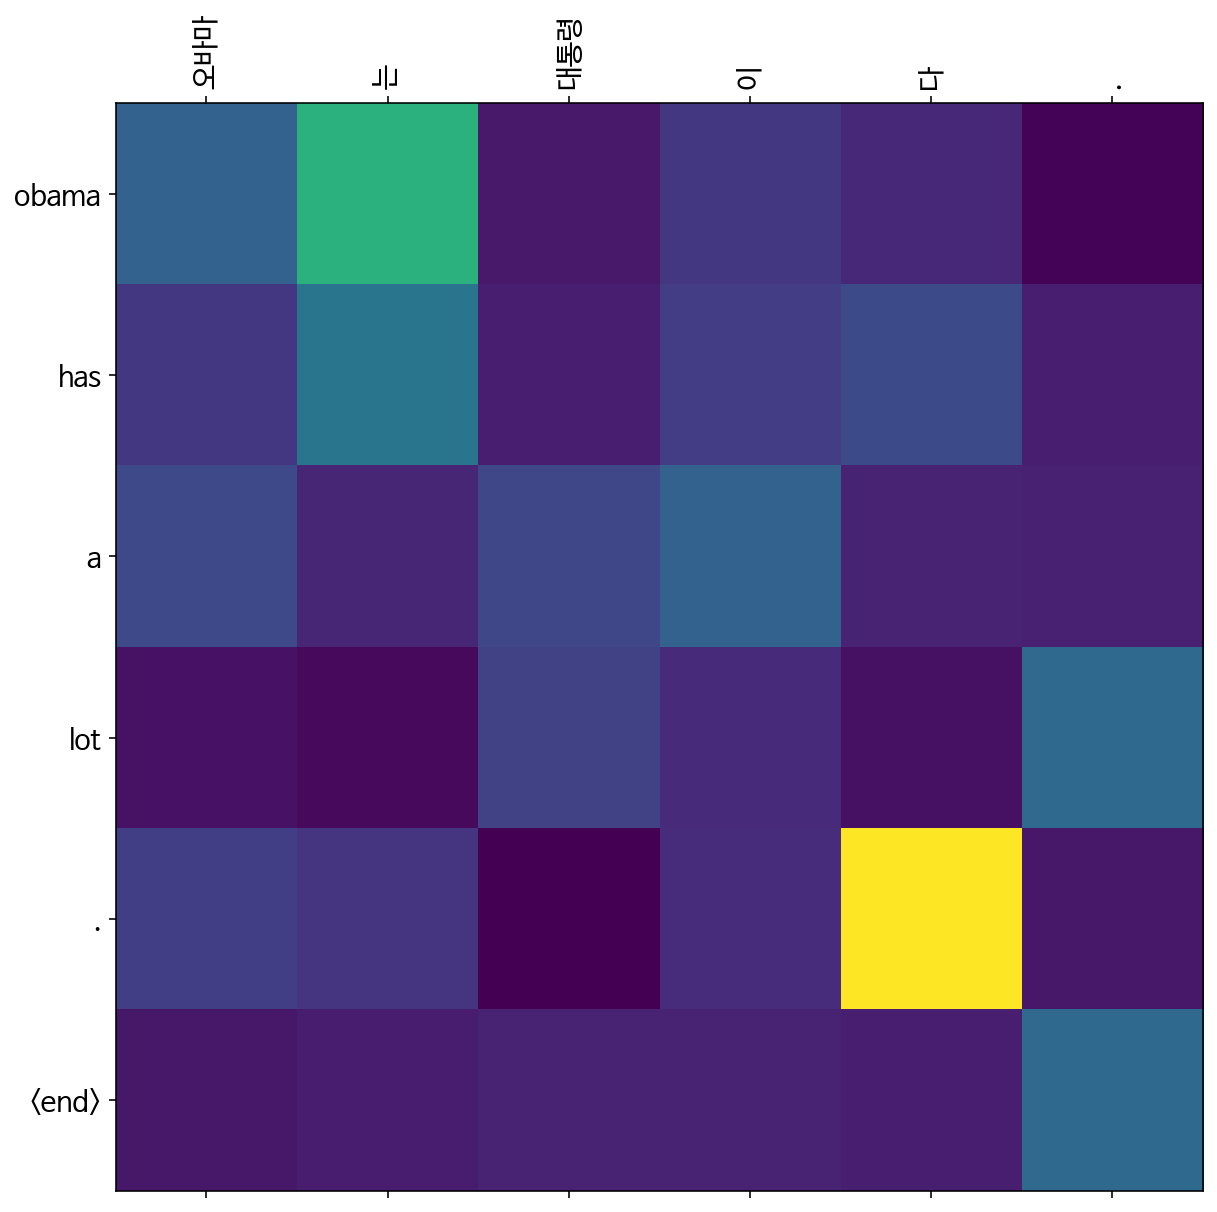

In [41]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: ['시민', '들', '은', '도시', '속', '에', '산다', '.']
Predicted translation: they are in the town . <end> 


/tmp/ipykernel_48/2811506968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/2811506968.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


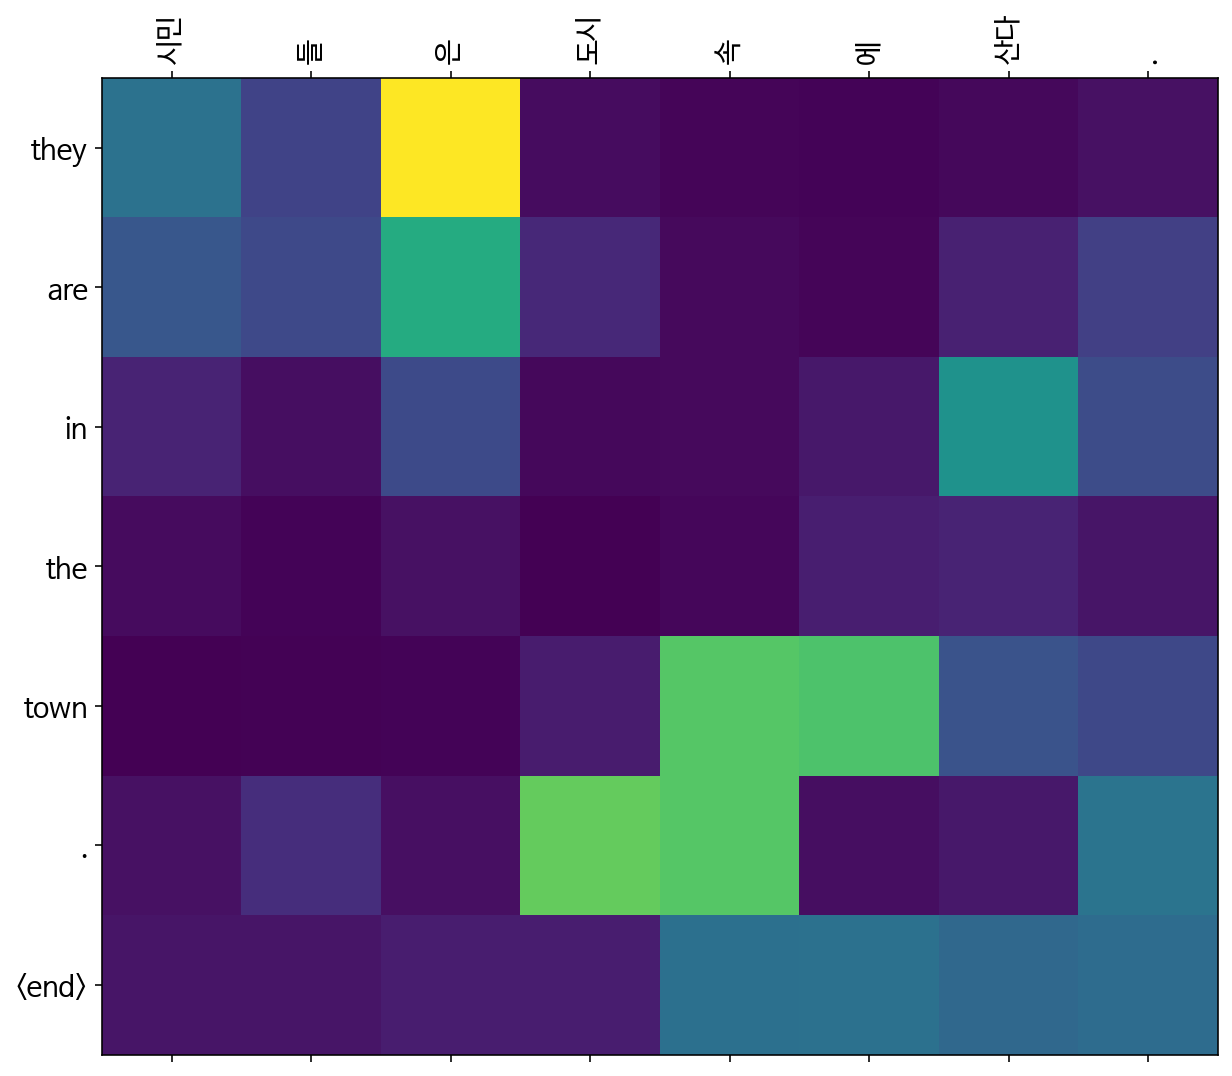

In [42]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: ['커피', '는', '필요', '없', '다', '.']
Predicted translation: it s no more efficient than anything . <end> 


/tmp/ipykernel_48/2811506968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/2811506968.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


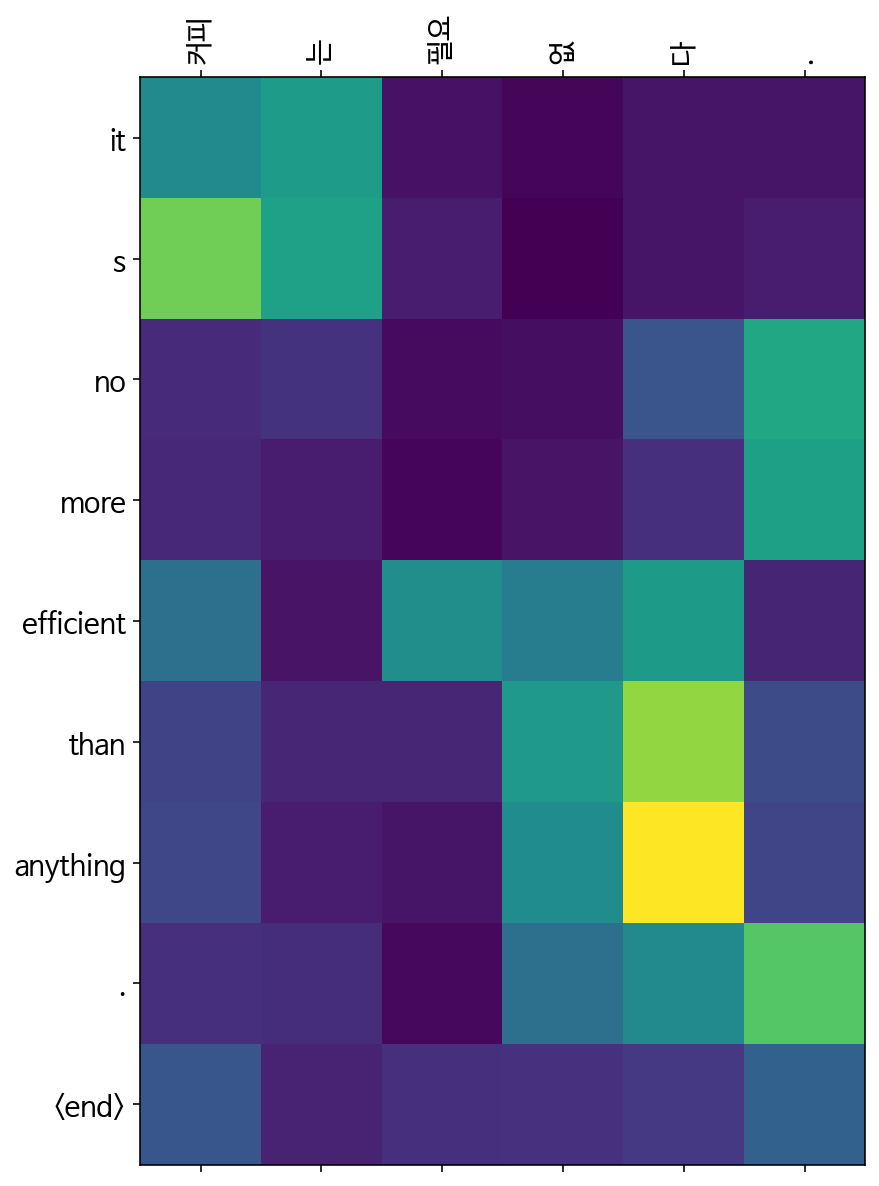

In [43]:
translate("커피는 필요 없다.", encoder, decoder)

Input: ['일곱', '명', '의', '사망자', '가', '발생', '했', '다', '.']
Predicted translation: seven people were killed . <end> 


/tmp/ipykernel_48/2811506968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/2811506968.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


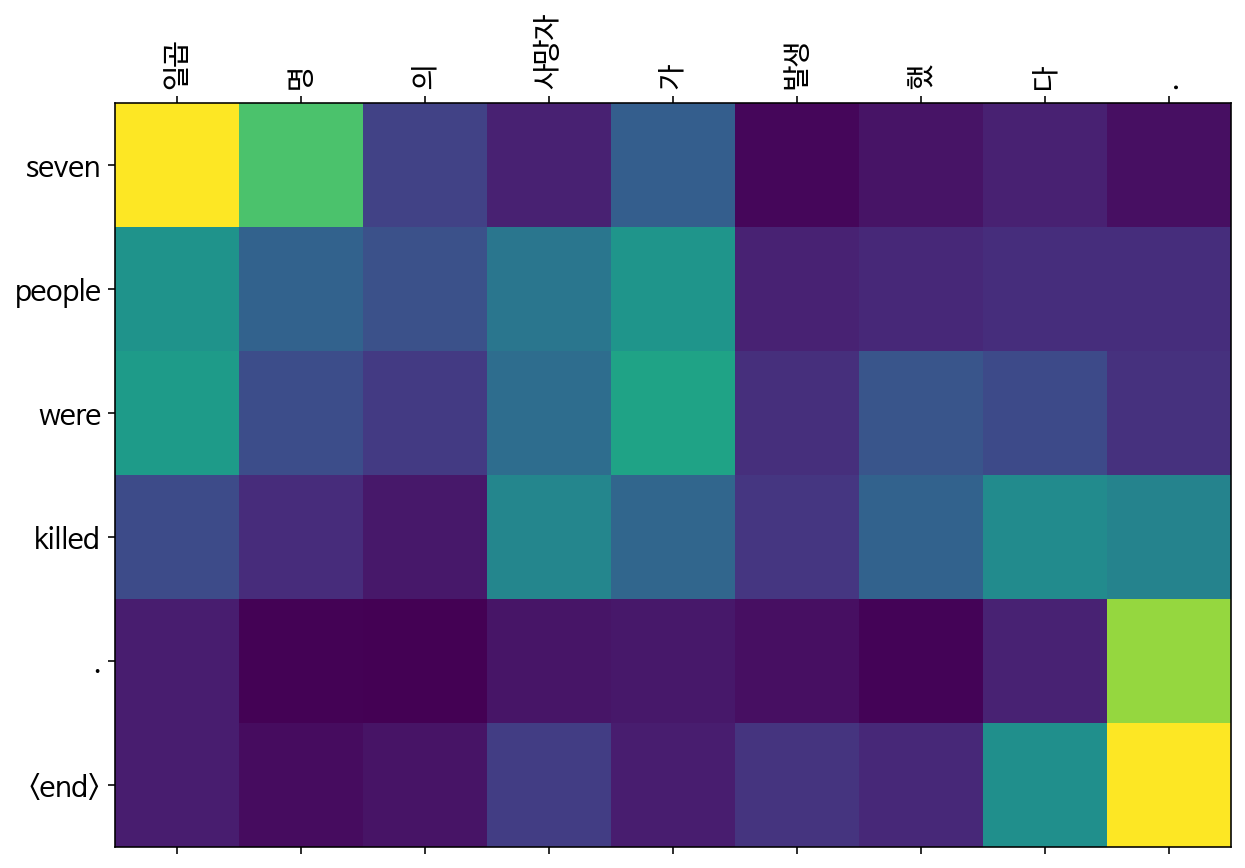

In [44]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

Input: ['핫도그', '3', '개', '주', '세요', '.']
Predicted translation: we are expected to be a lot of time . <end> 


/tmp/ipykernel_48/2811506968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/2811506968.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


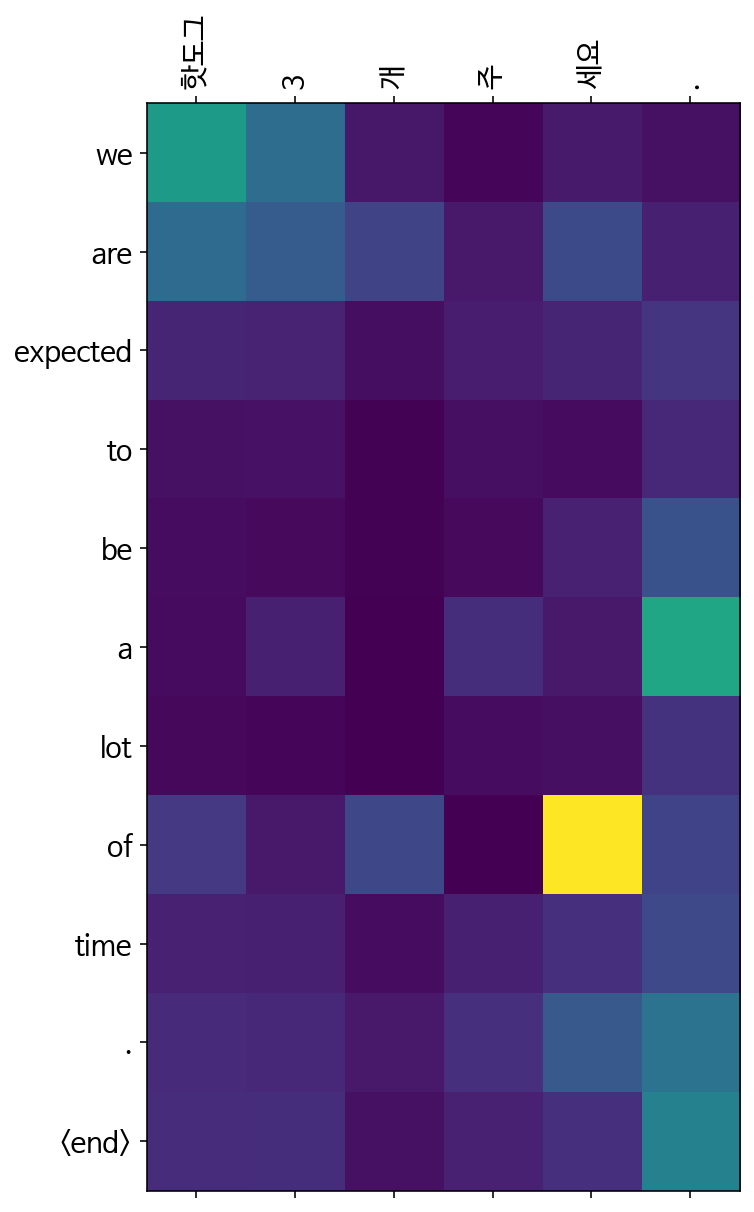

In [45]:
translate("핫도그 3개 주세요.", encoder, decoder)

Input: ['해리포터', '는', '재밌', '다']
Predicted translation: harry potter is more than usual <end> 


/tmp/ipykernel_48/2811506968.py:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipykernel_48/2811506968.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


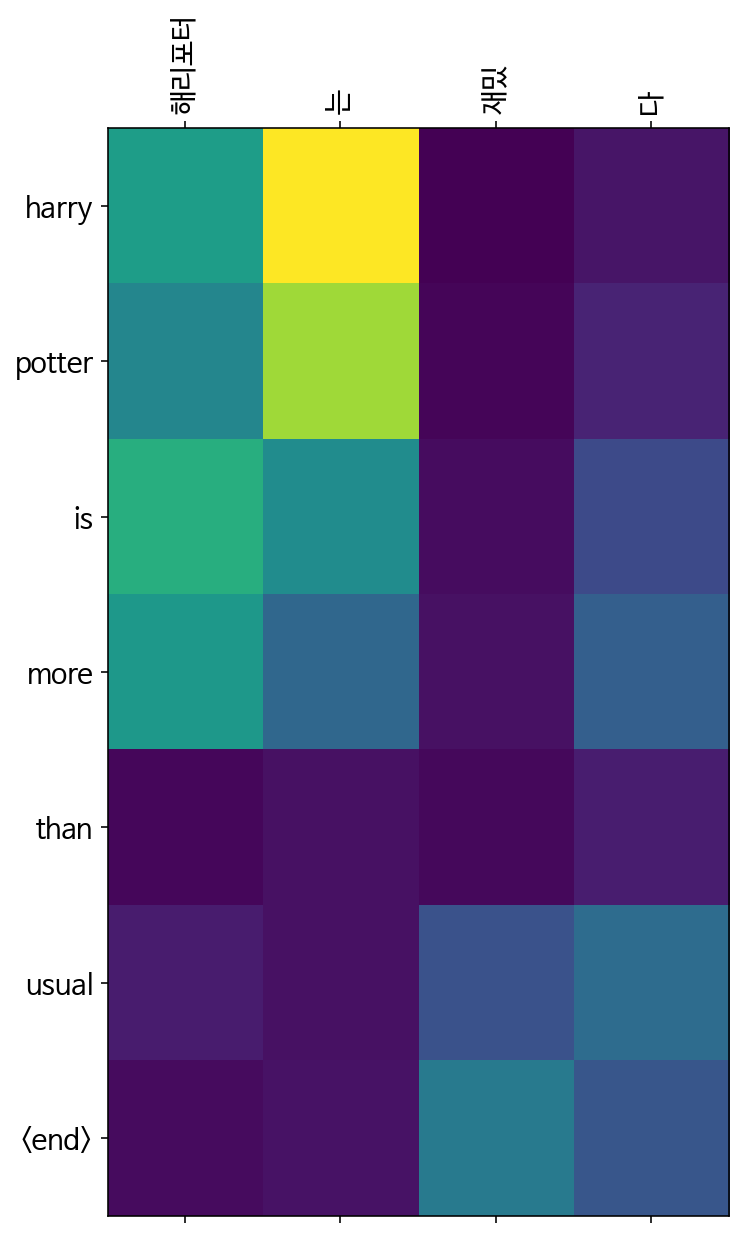

In [46]:
translate("해리포터는 재밌다", encoder, decoder)

###### 회고 : 정규표현식을 활용해서 한국어와 영어를 텍스트 전처리하였다. 그리고 training loss가 1.3732까지 떨어지면서 성공적으로 작동하였다. 모델을 만들고 디코딩을 하였는데, 처음에는 모델의 성능이 너무 나빠서 같은 단어가 계속 반복되는 무한루프 오류에 빠졌었다. 결국 런타임을 초기화하고 다시 돌렸더니 그나마 정상적인 수준으로 되었다. 지금도 번역이 제대로 안 된 거 같지만, 그전에 비하면 만족한다.